# TPC based Cosmic Rate measurement

## Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import glob
import time
from IPython.display import display, clear_output
import pandas as pd
from scipy.stats import circmean, circstd
import helpfunction as helper
%matplotlib inline

pd.options.display.max_columns=999

## Constants

In [2]:
main_tree_name = 'cosmicstudies'

# Input files
file_name_mc = './input/CosmicStudies_mc_75k_mcc9_nu.root'
file_name_data = './input/CosmicStudies_data_162k.root'

outdir = './Output/CosmicPfp/'

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])

gr = 1.618           # Golden ratio
good_start = -0.4e6  # Start of MC time where we are not biased by out of time charge
good_end = 0.5e6    # End of good MC time window (in ns)
t_begin = good_start/1e6
t_end = good_end/1e6
scatter_fraq = 0.05     # Number of points to include in scatter plots

## Functions

In [3]:
# Function should be able to work with arrays!
def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    mask_flip_dir = (mom_y>0)*2-1
    mom_x, mom_y, mom_z = mask_flip_dir*mom_x,mask_flip_dir*mom_y,mask_flip_dir*mom_z
    
    theta_cosmic = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_z)),mom_y)
    phi_cosmic = np.arctan2(mom_x,mom_z)
    if df_out:
        return pd.DataFrame({'zenith':theta_cosmic, 'azimuth':phi_cosmic})[['zenith','azimuth']]
    else:
        return np.array([theta_cosmic, phi_cosmic])

In [4]:
cosmic_angles(1,-1,0,df_out=False)

array([ 0.78539816, -1.57079633])

In [5]:
def cosmic_angles_start_end(x_s, y_s, z_s, x_e, y_e, z_e, df_out=True):
    return cosmic_angles(x_s-x_e, y_s-y_e, z_s-z_e, df_out)

In [6]:
cosmic_angles_start_end(-41.974457, 116.995811, 396.336456, 138.189041, -103.982864, 444.623535, df_out=False)

array([ 0.70104321, -1.83266001])

In [7]:
# To Do: update for logspace x axis
def histHelper(N,x_min,x_max,data,weights=0):
    edges = np.linspace(x_min,x_max,N+1)
    edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
    bins = [np.histogram(data_i,bins=edges)[0] for data_i in data]
    max_val = max([max(x) for x in bins])
    if weights==0:
        err = np.sqrt(bins)
    else:
        err = [helper.hist_bin_uncertainty(d_i, w_i, edges) for d_i, w_i in zip(data,weight)] 
    return edges, edges_mid, bins, err, max_val

## Load the data

In [8]:
file_mc = uproot.open(file_name_mc)[main_tree_name]
file_data = uproot.open(file_name_data)[main_tree_name]

In [9]:
file_mc.keys()

[b'pot;1',
 b'Event;1',
 b'MCParticles;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'PFParticles;1',
 b'Clusters;1',
 b'CRTcross;1']

In [10]:
file_mc[b'Event'].keys()

[b'event',
 b'run',
 b'subrun',
 b'pot',
 b'dataset_prescale_factor',
 b'num_simplebeamflashes',
 b'num_opbeamflashes',
 b'num_simplecosmicflashes',
 b'num_opcosmicflashes',
 b'num_pfp',
 b'num_pfp_saved',
 b'num_mcp',
 b'num_mcp_saved',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc']

In [11]:
# Load events df
cols = [b'event', b'run', b'subrun', 
        b'num_pfp', b'num_pfp_saved', b'num_mcp', b'num_mcp_saved']

df_event_mc = file_mc[b'Event'].pandas.df(cols)
df_event_data = file_data[b'Event'].pandas.df()

n_mc = len(df_event_mc)
n_data = len(df_event_data)
mc_scale = n_data/n_mc
print("Events in MC: ", n_mc, "\t Events in data: ", n_data,".")

Events in MC:  79400 	 Events in data:  161940 .


In [12]:
df_event_mc.keys()

Index(['event', 'run', 'subrun', 'num_pfp', 'num_pfp_saved', 'num_mcp',
       'num_mcp_saved'],
      dtype='object')

In [13]:
# Load mcp df
df_mcp = file_mc[b'MCParticles'].pandas.df()
# Add the true zenith/azimuth angles at generation
cols = ['mc_startmomentumx', 'mc_startmomentumy', 'mc_startmomentumz']
df_mcp[['mc_zenith_true','mc_azimuth_true']] = cosmic_angles(*df_mcp[cols].T.values)
cols = ['mc_startx_tpc', 'mc_starty_tpc', 'mc_startz_tpc', 
        'mc_endx_tpc', 'mc_endy_tpc', 'mc_endz_tpc']
df_mcp[['mc_zenith_traj','mc_azimuth_traj']] = cosmic_angles_start_end(*df_mcp[cols].T.values)
df_mcp['time_drift_ok'] = df_mcp['mc_time'].between(good_start,good_end)
df_mcp.keys()
print("Memory usage in megabyte: {0:.1f}".format(df_mcp.memory_usage(index=True, deep=True).sum()*1e-6))

Memory usage in megabyte: 3055.7


In [14]:
print(df_mcp.query("mc_is_matched==1")['mc_pdg_code'].value_counts())

 2112    4150959
-13       916261
 13       796075
 2212     617253
 11       387508
 22       256218
-11       126052
 211       14350
-211       10177
 111        6652
-2212         26
-2112         16
Name: mc_pdg_code, dtype: int64


In [15]:
# Load pfp df
df_pfp_mc = file_mc[b'PFParticles'].pandas.df()
df_pfp_data = file_data[b'PFParticles'].pandas.df()

# Add the reco zenith/azimuth angles fro reco particles based on the start momentum
cols= ['track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz']
df_pfp_mc[['pfp_zenith_start','pfp_azimuth_start']] = cosmic_angles(*df_pfp_mc[cols].T.values)
df_pfp_data[['pfp_zenith_start','pfp_azimuth_start']] = cosmic_angles(*df_pfp_data[cols].T.values)
# Add the reco zenith/azimuth angles fro reco particles based on the trajectory
cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
df_pfp_mc[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_mc[cols].T.values)
df_pfp_data[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_data[cols].T.values)

# Add the true zenith/azimuth angles at generation
cols = ['track_matched_startmomentumx', 'track_matched_startmomentumy', 'track_matched_startmomentumz']
df_pfp_mc[['mc_zenith_true','mc_azimuth_true']] = cosmic_angles(*df_pfp_mc[cols].T.values)
# Add the reco zenith/azimuth angles for tuth particles based on the trajectory
cols = ['track_matched_startx_sce', 'track_matched_starty_sce', 'track_matched_startz_sce', 
        'track_matched_endx_sce', 'track_matched_endy_sce', 'track_matched_endz_sce']
df_pfp_mc[['mc_zenith_traj','mc_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_mc[cols].T.values)

# Add if tracks are broken:
df_pfp_mc['broken_pfp'] = df_pfp_mc.duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
df_pfp_mc['time_drift_ok'] = df_pfp_mc['track_matched_time'].between(good_start,good_end)
df_pfp_mc['mc_avgx'] = (df_pfp_mc['track_matched_startx']+df_pfp_mc['track_matched_endx'])/2
df_pfp_mc['mc_avgx_sce'] = (df_pfp_mc['track_matched_startx_sce']+df_pfp_mc['track_matched_endx_sce'])/2

In [16]:
print(df_pfp_mc.keys())
print("Memory usage in megabyte: {0:.1f}".format(df_pfp_mc.memory_usage(index=True, deep=True).sum()*1e-6))

Index(['event', 'run', 'subrun', 'num_pfp', 'num_mcp', 'num_mcp_saved',
       'num_flashes', 'pdg_code', 'num_daughters', 'is_primary', 'n_hits',
       'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
       'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
       'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
       'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
       'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
       'track_mcs_momentum', 'track_mcs_mom_err', 'track_mcs_likelihood',
       'track_mcs_energy', 'track_matched_pdgcode', 'track_matched_energy',
       'track_matched_kBeamNeutrino', 'track_matched_time',
       'track_matched_process', 'track_matched_end_process',
       'track_matched_startinside', 'track_matched_endinside',
       'track_matched_partinside', 'track_matched_startx',
       'track_matched_starty', 't

## DataFrame preparation

In [17]:
# 1. All inTPC muons, mcparticles
primary_query = '(mc_process==23)'
muon_query = '(mc_pdg_code==13 | mc_pdg_code==-13)'
intpc_query = '(mc_length_tpc>10)' 
clean_query =  "(track_length>25)"
df_mc_muon_cross = df_mcp.query(primary_query+' & '+muon_query+ ' & '+intpc_query)
# Save your memory!
del df_mcp

# 2. All matched inTPC muons, deduplicated
primary_matched_query = '(track_matched_process==23)'
muon_matched_query = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13)'
intpc_matched_query = '(track_matched_length_tpc>10)' 
matched_query = primary_matched_query+' & '+muon_matched_query+ ' & '+intpc_matched_query
df_pfp_matched_unique = df_pfp_mc.drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)

# 3. Split the reconstructed tracks in 3 categories:
query_cat1 = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13) & broken_pfp==0'
query_cat2 = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13) & broken_pfp==1'
query_cat3 = '(track_matched_pdgcode!=13 & track_matched_pdgcode!=-13)'
query_arr = [query_cat1, query_cat2, query_cat3]
label_arr = ['Muon matched', 'Muon matched, broken', 'Other matched']
df_arr = [df_pfp_mc.query(q) for q in query_arr]

In [18]:
# Fix the field of neutrino origin using the time
#df_mc_muon_cross["mc_neutrino_origin"] = df_mc_muon_cross["mc_time"].between(3.15e3,4.8e3)
#df_pfp_mc["track_matched_kBeamNeutrino"] = df_pfp_mc["track_matched_time"].between(3.15e3,4.8e3)
#df_pfp_mc["track_matched_kBeamNeutrino"] = df_pfp_mc['track_matched_kBeamNeutrino'] >= df_pfp_mc['track_matched_kBeamNeutrino'].mean()

In [19]:
#df_pfp_mc["track_matched_kBeamNeutrino"].value_counts()
nu_ori_mc = "(mc_neutrino_origin==0)"
nu_ori_reco = "(track_matched_kBeamNeutrino==0)"

df_pfp_mc = df_pfp_mc.query(nu_ori_reco)
df_mc_muon_cross = df_mc_muon_cross.query(nu_ori_mc)

## Plots

[22.638824166551217, 18.928887242188466]
Deficit of reconstructed 5cm + tracks in data:  16.4%
[18.794871471932897, 15.204267012473755]
Deficit of reconstructed 5cm + tracks in data:  19.1%


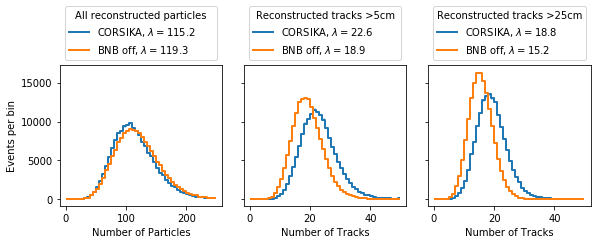

In [20]:
fig, ax = plt.subplots(ncols = 3, sharey=True, figsize=(8.5,3.5))
labs=['CORSIKA', 'BNB off']

field = 'num_pfp'
N=50
x_min = 0
x_max = 250
data = [df_event_mc[field], df_event_data[field]]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
means = ([x.mean() for x in data])
weights = [mc_scale, 1]
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[0].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[0].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='All reconstructed particles', loc='lower center', mode='expand')
ax[0].set_xlabel("Number of Particles")
ax[0].set_ylabel("Events per bin")

field = 'num_pfp_saved'
x_max = 50
#data = [df_event_mc[field], df_event_data[field]]
data = [df_pfp_mc.groupby(['run', 'subrun', 'event', 'num_mcp']).size(),
        df_pfp_data.groupby(['run', 'subrun', 'event']).size()]
means= [x.mean() for x in data]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[1].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[1].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >5cm', loc='lower center', mode='expand')
ax[1].set_xlabel("Number of Tracks")
print(means)
print('Deficit of reconstructed 5cm + tracks in data:  {0:.1f}%'.format(100-means[1]/means[0]*100))


x_max=50
clean_tracks = [df_pfp_mc.query(clean_query).groupby(['run', 'subrun', 'event', 'num_mcp']).size(),
                df_pfp_data.query(clean_query).groupby(['run', 'subrun', 'event']).size()]
means= [x.mean() for x in clean_tracks]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, clean_tracks)
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[2].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[2].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[2].set_xlabel("Number of Tracks")
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >25cm', loc='lower center', mode='expand')
print(means)
print('Deficit of reconstructed 5cm + tracks in data:  {0:.1f}%'.format(100-means[1]/means[0]*100))

fig.tight_layout()
plt.savefig(outdir+"num_pfp.pdf", bbox_inches="tight")

In [21]:
# How often is a reco primary track of 5cm matched to a muons? 95% of the cases to a muon
df_pfp_mc['track_matched_pdgcode'].value_counts()/len(df_pfp_mc)*100
df_pfp_matched_unique = df_pfp_mc.drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)

In [22]:
# How often does a good mc muon get matched? only 50% of the time!
# What happens to the other muons? True time dependency?
print('Reconstruction efficiency, no time cut:')
counts= df_mc_muon_cross['mc_is_matched'].value_counts()
print("All pfp, Fraction of true crossing muons that was matched",counts[True]/sum(counts)*100)
print("5cm+\t Fraction of true crossing muons that was matched",len(df_mc_muon_cross_matched)/sum(counts)*100)
df_pfp_matched_unique_25 = df_pfp_mc.query(clean_query).drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched_25 = df_pfp_matched_unique_25.query(matched_query)
print("25cm+\t Fraction of true crossing muons that was matched",len(df_mc_muon_cross_matched_25)/sum(counts)*100)

Reconstruction efficiency, no time cut:
All pfp, Fraction of true crossing muons that was matched 52.46738499241346
5cm+	 Fraction of true crossing muons that was matched 51.497574181096375
25cm+	 Fraction of true crossing muons that was matched 47.31025096616126


In [23]:
# Purity comparison if the track is 5cm+ or 25cm+:
print("Muon PDG Purity:")
frq = len(df_pfp_mc.query(muon_matched_query))/len(df_pfp_mc)*100
print('5cm+\tFraction of reco tracks matched to true muons:', frq)
frq = len(df_pfp_mc.query(clean_query).query(muon_matched_query))/len(df_pfp_mc.query(clean_query))*100
print('25cm+\tFraction of reco tracks matched to true muons:', frq)

# Caluclation of broken tracks if it is a muon!
#After 5cm cut
broken_pure_bool = df_pfp_mc.query(muon_matched_query).duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
print('Fraction of reco tracks that are broken:', sum(broken_pure_bool)/len(broken_pure_bool)*100)
broken_pure_bool = df_pfp_mc.query(muon_matched_query).groupby(['track_matched_time', 'track_matched_energy']).size()
print('Fraction of true tracks that are broken:', sum(broken_pure_bool>1)/len(broken_pure_bool)*100)
#After 25cm cut:
broken_pure_bool = df_pfp_mc.query(clean_query).query(muon_matched_query).duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
print('Fraction of reco tracks that are broken:', sum(broken_pure_bool)/len(broken_pure_bool)*100)
broken_pure_bool = df_pfp_mc.query(clean_query).query(muon_matched_query).groupby(['track_matched_time', 'track_matched_energy']).size()
print('Fraction of true tracks that are broken:', sum(broken_pure_bool>1)/len(broken_pure_bool)*100)

Muon PDG Purity:
5cm+	Fraction of reco tracks matched to true muons: 95.47304589707927
25cm+	Fraction of reco tracks matched to true muons: 99.03129008090899
Fraction of reco tracks that are broken: 11.07976794271756
Fraction of true tracks that are broken: 5.129050006683308
Fraction of reco tracks that are broken: 1.6166183302906003
Fraction of true tracks that are broken: 0.7604321378647563


count    3.096274
mean    -0.425976
std      2.094850
min     -4.049999
25%     -2.240996
50%     -0.428337
75%      1.390797
max      3.199999
Name: mc_time, dtype: float64

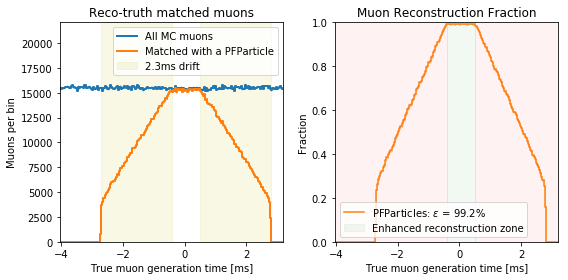

In [47]:
# How many of the true muons do we match in function of time, every match is okay
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))
field = 'mc_time'

N=200
x_min=min(df_mc_muon_cross[field]/1e6)
x_max=max(df_mc_muon_cross[field]/1e6)
labs=['All MC muons', 'Matched with a PFParticle']
data=[df_mc_muon_cross[field]/1e6, df_mc_muon_cross.query("mc_is_matched==1")[field]/1e6]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)

for b_i, w_i, lab_i, err_i in zip(bins,weights,labs, err):
    ax[0].step(edges_mid,b_i,lw=2, label=lab_i, where='mid')
    ax[0].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
    
ax[0].set_xlabel(r'True muon generation time [ms]')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_ylim(0,max_y*1.4)
ax[0].set_xlim(x_min,x_max)
ax[0].set_title('Reco-truth matched muons')
ax[0].axvspan(t_begin-2.3,t_begin, alpha=0.1, color="y", label='2.3ms drift')
ax[0].axvspan(t_end,t_end+2.3, alpha=0.1, color="y")
ax[0].legend()

denom,_ = np.histogram(data[0], bins=edges)
nom,_ = np.histogram(data[1], bins=edges)
fraq = nom/denom
ratio = sum(data[1].between(t_begin,t_end))/sum(data[0].between(t_begin,t_end))

err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label=r'PFParticles: $\varepsilon$ = {0:.1f}%'.format(ratio*100), color='C1')
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon generation time [ms]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Muon Reconstruction Fraction')
ax[1].axvspan(x_min,t_begin, alpha=0.05, color="red")
ax[1].axvspan(t_begin,t_end, alpha=0.05, color="green", label=r'Enhanced reconstruction zone')
ax[1].axvspan(t_end,x_max, alpha=0.05, color="red")
ax[1].legend()

fig.tight_layout()
plt.savefig(outdir+"match_eff.pdf", bbox_inches="tight")
df_mc_muon_cross[field].describe()/1e6

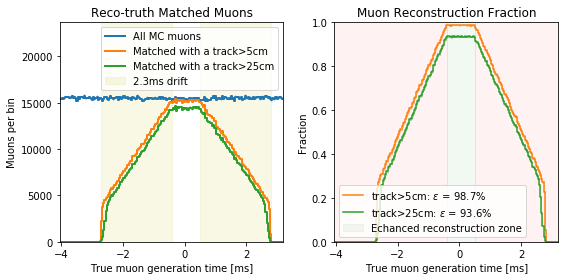

In [48]:
#Now the plotting part 
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))
N=200
x_min=min(df_mc_muon_cross[field]/1e6)
x_max=max(df_mc_muon_cross[field]/1e6)
labs=['All MC muons', 'Matched with a track>5cm', 'Matched with a track>25cm']
data=[df_mc_muon_cross['mc_time']/1e6, 
      df_mc_muon_cross_matched['track_matched_time']/1e6, 
      df_mc_muon_cross_matched.query(clean_query)['track_matched_time']/1e6]
weights = [1, 1, 1]

edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)

for b_i, w_i, lab_i, err_i in zip(bins,weights,labs, err):
    ax[0].step(edges_mid,b_i,lw=2, label=lab_i, where='mid')
    ax[0].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
    
ax[0].set_xlabel(r'True muon generation time [ms]')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_ylim(0,max_y*1.5)
ax[0].set_xlim(x_min,x_max)
ax[0].set_title('Reco-truth Matched Muons')

ax[0].axvspan(t_begin-2.3,t_begin, alpha=0.1, color="y", label='2.3ms drift')
ax[0].axvspan(t_end,t_end+2.3, alpha=0.1, color="y")
ax[0].legend()

denom,_ = np.histogram(data[0], bins=edges)
nom,_ = np.histogram(data[1], bins=edges)
nom25,_ = np.histogram(data[2], bins=edges)
fraq = nom/denom
fraq25 = nom25/denom
ratio = sum(data[1].between(t_begin,t_end))/sum(data[0].between(t_begin,t_end))
ratio25 = sum(data[2].between(t_begin,t_end))/sum(data[0].between(t_begin,t_end))

err = np.sqrt( fraq*(1-fraq)/denom )
err25 = np.sqrt( fraq25*(1-fraq25)/denom )

ax[1].step(edges_mid, fraq, where='mid',color="C1",
                   label=r'track>5cm: $\varepsilon$ = {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')
ax[1].step(edges_mid, fraq25, where='mid',color="C2",
                   label=r'track>25cm: $\varepsilon$ = {0:.1f}%'.format(ratio25*100))
ax[1].fill_between(edges_mid, fraq25 - err25, fraq25 + err25, alpha=0.3, step='mid', color='C2')
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon generation time [ms]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Muon Reconstruction Fraction')
ax[1].axvspan(x_min,t_begin, alpha=0.05, color="red")
ax[1].axvspan(t_begin,t_end, alpha=0.05, color="green", label=r'Echanced reconstruction zone')
ax[1].axvspan(t_end,x_max, alpha=0.05, color="red")
ax[1].legend()

fig.tight_layout()
plt.savefig(outdir+"match_eff_track5cm.pdf", bbox_inches="tight")

Estimated size of the systematic due to the CORSIKA bug is -0.00%


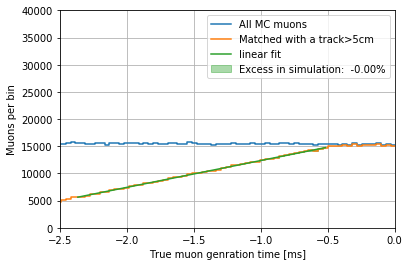

In [26]:
# Try to quantify the excess in Matched mc muons!
import numpy.polynomial.polynomial as poly

plt.step(edges_mid,bins[0],where='mid', label=labs[0])
plt.step(edges_mid,bins[1],where='mid', label=labs[1])
plt.xlim(-2.5,0)
plt.ylim(0,40000)
plt.grid(True)
plt.xlabel("True muon genration time [ms]")
plt.ylabel("Muons per bin")

mask = (-2.4<np.array(edges_mid)) & (np.array(edges_mid)<-0.9)
x = np.array(edges_mid)[mask]
y = np.array(bins[1])[mask]
coefs = np.polyfit( x,y,1)

mask = (-2.4<np.array(edges_mid)) & (np.array(edges_mid)<-0.5)
x_new = np.array(edges_mid)[mask]
ffit = poly.polyval(x_new, coefs[::-1])
plt.plot(x_new,ffit, label = 'linear fit')

mask = (-0.9<np.array(edges_mid)) & (np.array(edges_mid)<-0.5)
y_fit = poly.polyval(np.array(edges_mid)[mask], coefs[::-1])
syst_frq = sum(np.array(bins[1])[mask] - y_fit)/sum(bins[1])
plt.fill_between(np.array(edges_mid)[mask], y_fit , np.array(bins[1])[mask], alpha=0.4, step='mid', 
                 label= "Excess in simulation:  {0:.2f}%".format(syst_frq*100), color='C2')
print("Estimated size of the systematic due to the CORSIKA bug is {0:.2f}%".format(syst_frq*100))
plt.legend()
fig.tight_layout()
plt.savefig(outdir+"corsika_bug_est.pdf", bbox_inches="tight")

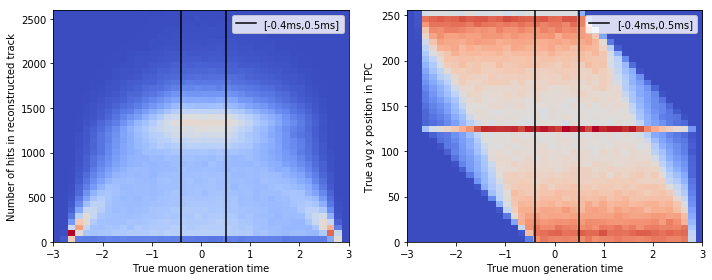

In [27]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(10,4))

ax[0].hist2d(df_mc_muon_cross_matched['track_matched_time']/1e6,df_mc_muon_cross_matched['n_hits'],range=((-3,3),(0,2600)), bins=(40,40), cmap="coolwarm")
ax[0].set_xlabel('True muon generation time')
ax[0].set_ylabel('Number of hits in reconstructed track')
ax[0].axvline(x=t_begin,color='k', label='[-0.4ms,0.5ms]')
ax[0].axvline(x=t_end,color='k')
ax[0].legend()

ax[1].hist2d(df_mc_muon_cross_matched['track_matched_time']/1e6,df_mc_muon_cross_matched['mc_avgx'],range=((-3,3),(0,256)), bins=(40,40), cmap="coolwarm")
ax[1].set_xlabel('True muon generation time')
ax[1].set_ylabel(r'True avg $x$ position in TPC')
ax[1].axvline(x=t_begin,color='k', label='[-0.4ms,0.5ms]')
ax[1].axvline(x=t_end,color='k')
ax[1].legend()
fig.tight_layout()
plt.savefig(outdir+"mc_time_2d.pdf", bbox_inches="tight")

In [28]:
df_pfp_mc['track_matched_pdgcode'].value_counts()

-13      938043
 13      778085
 2112     28498
 22       26961
 2212      8233
 11        8140
-11        7873
 211        901
-211        623
-2212        84
 321         27
-321         19
-2112         6
-3222         3
 3112         2
 3222         1
 3312         1
Name: track_matched_pdgcode, dtype: int64

In [29]:
df_pfp_mc.query('broken_pfp')['track_matched_pdgcode'].value_counts()*100/df_pfp_mc['track_matched_pdgcode'].value_counts()

-3222    100.000000
-2212     96.428571
-2112     83.333333
-321     100.000000
-211      67.415730
-13       11.595844
-11       57.805157
 11       57.604423
 13       10.457598
 22       35.670042
 211      77.358491
 321      92.592593
 2112     36.153414
 2212     58.739220
 3112           NaN
 3222           NaN
 3312           NaN
Name: track_matched_pdgcode, dtype: float64

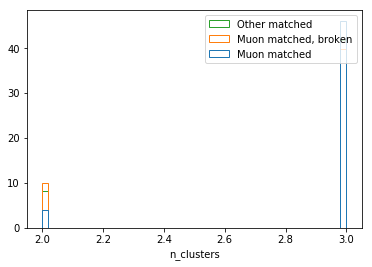

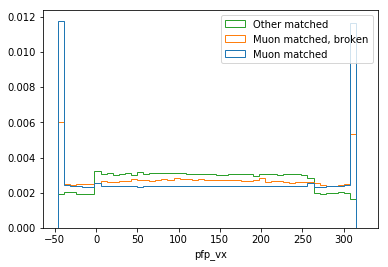

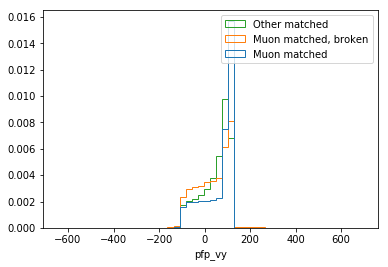

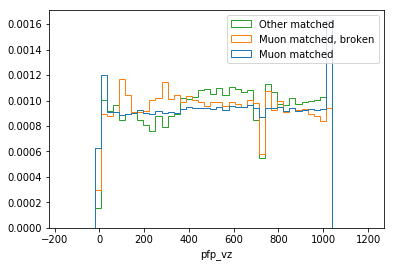

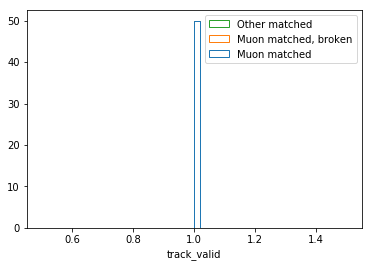

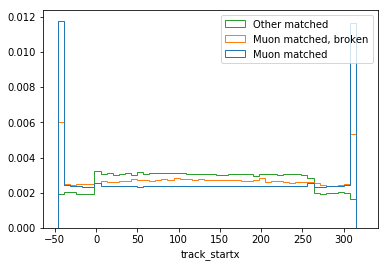

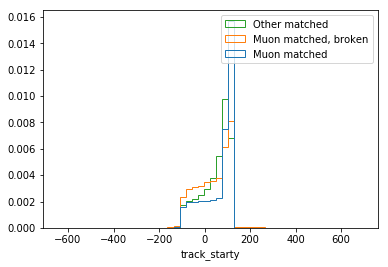

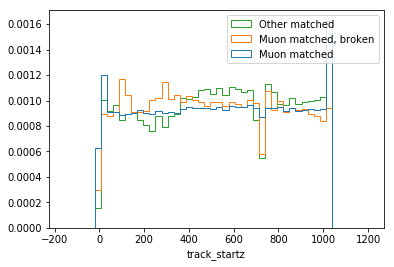

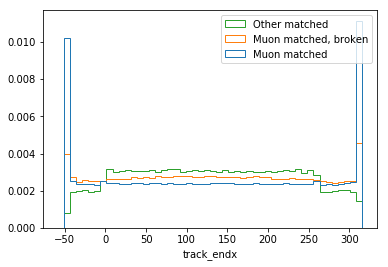

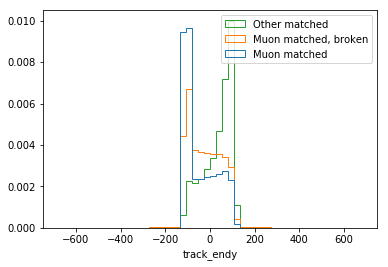

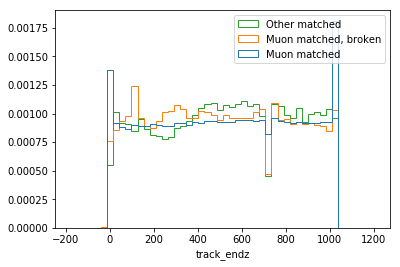

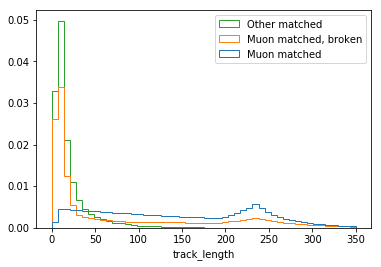

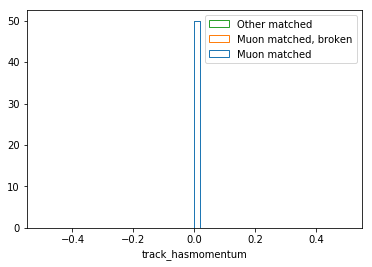

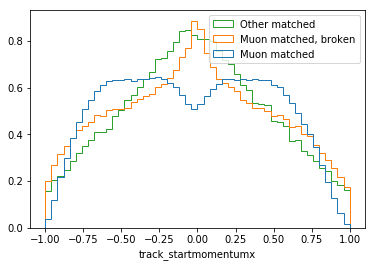

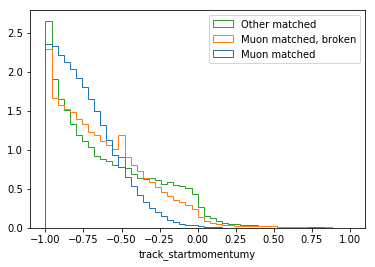

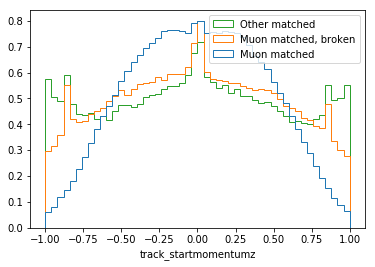

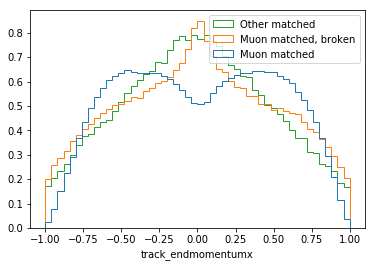

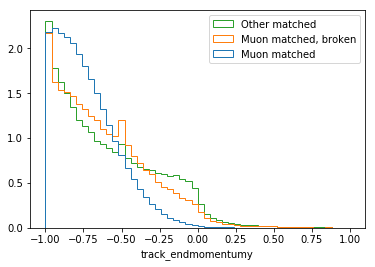

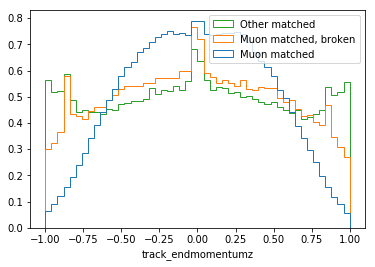

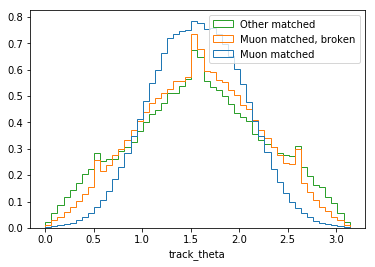

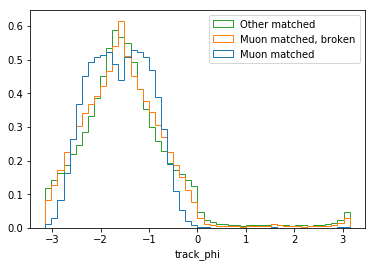

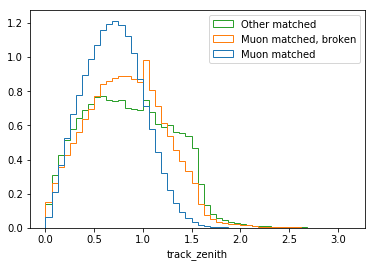

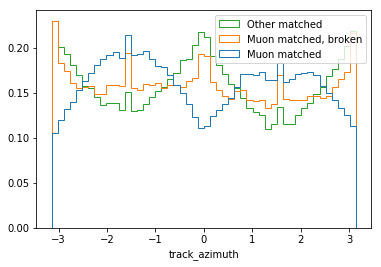

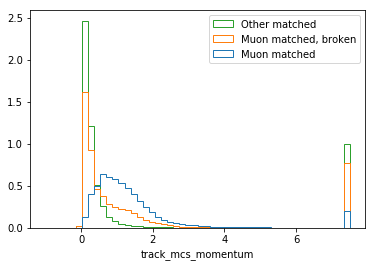

In [30]:
fields = [ 'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
           'track_startx', 'track_starty', 'track_startz', 'track_endx',
           'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
           'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
           'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
           'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
           'track_mcs_momentum'
         ]


for field in fields:
    data = [df[field] for df in df_arr]
    if field=='track_length':
        plt.hist(data, histtype='step',label=label_arr,density=1, bins=50, range=(0,350))
    else:
        plt.hist(data, histtype='step',label=label_arr,density=1, bins=50)
    plt.legend()
    plt.xlabel(field)
    plt.show()

## Angular stuff

[1, 1.9418390398029233]
[1, 1.9418390398029233]


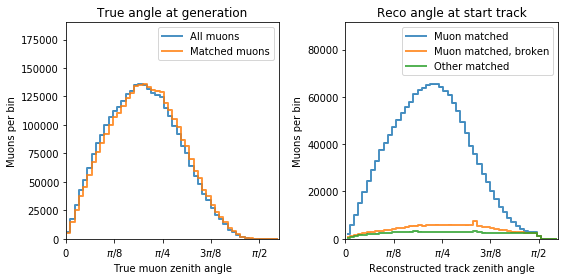

In [31]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))

N=50
x_min=0
x_max=np.pi/2*1.1

data=[df_mc_muon_cross['mc_zenith_true'], df_mc_muon_cross_matched['mc_zenith_true']]
labs=['All muons', 'Matched muons']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
scale = [1, len(df_mc_muon_cross)/len(df_mc_muon_cross_matched)]

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    print(scale)
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend()
ax[0].set_xlabel(r'True muon zenith angle')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_title('True angle at generation')
ax[0].set_ylim(0, max_y*1.4)


data = [df['pfp_zenith_start'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'Reconstructed track zenith angle')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_title('Reco angle at start track')
ax[1].set_ylim(0, max_y*1.4)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_start.pdf", bbox_inches="tight")

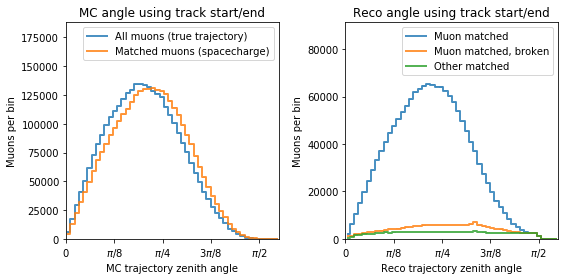

In [32]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))

N=50
x_min=0
x_max=np.pi/2*1.1

data=[df_mc_muon_cross['mc_zenith_traj'], df_mc_muon_cross_matched['mc_zenith_traj']]
labs=['All muons (true trajectory)', 'Matched muons (spacecharge)']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend()
ax[0].set_xlabel(r'MC trajectory zenith angle')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_title('MC angle using track start/end')
ax[0].set_ylim(0, max_y*1.4)


data = [df['pfp_zenith_traj'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'Reco trajectory zenith angle')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_title('Reco angle using track start/end')
ax[1].set_ylim(0, max_y*1.4)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_tpctraj.pdf", bbox_inches="tight")

[14.21354631  8.37369938  6.16096548  5.31791253  4.46607449  4.15125975
  3.84915088  3.5248962   3.4104535   3.34884303  3.31827423  3.28402443
  3.44873051  3.58283704  3.83616367  4.32748881  5.02443914  5.94627492
  7.02906383  8.20438595]


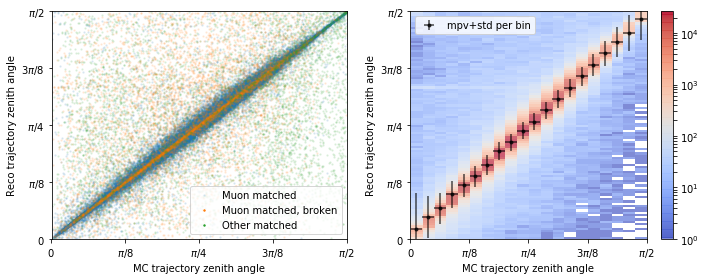

In [34]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey = False, figsize=(10,4))
fld_mc, fld_reco = 'mc_zenith_traj', 'pfp_zenith_traj'

for df,lab in zip(df_arr,label_arr):
    temp = df.sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],
                  temp[fld_reco],s=2,alpha=0.1,label=lab)
leg = ax[0].legend()
for lh in leg.legendHandles[1:]: 
    lh.set_alpha(1)

h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0][fld_mc],df_arr[0][fld_reco], 
                                    label = label_arr[0], cmap='coolwarm', bins=(20,100), alpha= 0.65,norm=colors.LogNorm())
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n in h:
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    mean = np.average(mids_y, weights=n)
    var = np.average((mids_y - mean)**2, weights=n)
    mean = mids_y[np.argmax(n)]
    y_err.append(np.sqrt(var))
    y_mean.append(mean)
print(np.array(y_err)/np.pi*180)
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mpv+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')


ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_yticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_yticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_yticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_yticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_xlabel('MC trajectory zenith angle')
ax[0].set_ylabel('Reco trajectory zenith angle')
ax[1].set_xlabel('MC trajectory zenith angle')
ax[1].set_ylabel('Reco trajectory zenith angle')
ax[0].set_ylim(0,np.pi/2)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_2d_ysce100.png", bbox_inches="tight", dpi=300)

[14.40645675 10.66507683  9.55939407  9.74052236 10.53552753 10.47736089
  9.34737055  9.58352882 10.52306171 14.84748882 14.33076126 10.26200205
  9.15670786  9.16744784 10.56494313 10.75394524  9.40970819  9.41879882
 10.38081707 14.18691794]


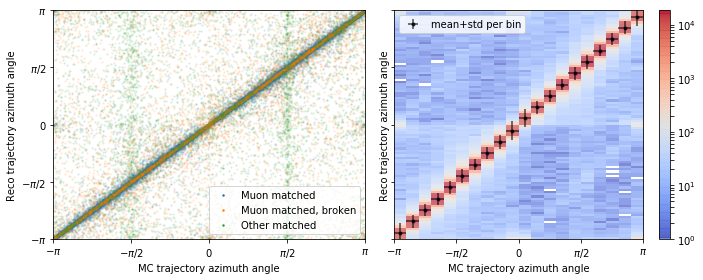

In [36]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=True, figsize=(10,4))
fld_mc, fld_reco = 'mc_azimuth_traj', 'pfp_azimuth_traj'

for df,lab in zip(df_arr,label_arr):
    temp = df.sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],temp[fld_reco],s=2,alpha=0.1,label=lab)
    leg = ax[0].legend(loc='lower right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0][fld_mc],df_arr[0][fld_reco], label = label_arr[0], 
                                    cmap='coolwarm', bins=(20,100), alpha= 0.65, norm=colors.LogNorm())
#,norm=colors.LogNorm())
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n in h:
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    angles = np.repeat(mids_y,n.astype(int))
    mean = circmean(angles,low=-np.pi, high=np.pi)
    std = circstd(angles-mean,low=-np.pi, high=np.pi)
    #mean = mids_y[np.argmax(n)]
    y_err.append(std)
    y_mean.append(mean)
print(np.array(y_err)/np.pi*180)
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mean+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')


ax[1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[1].set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[0].set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[1].set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[0].set_xlabel('MC trajectory azimuth angle')
ax[0].set_ylabel('Reco trajectory azimuth angle')
ax[1].set_xlabel('MC trajectory azimuth angle')
ax[1].set_ylabel('Reco trajectory azimuth angle')
ax[0].set_ylim(-np.pi,np.pi)

fig.tight_layout()
plt.savefig(outdir+"trackazimuth_2d.png", bbox_inches="tight", dpi=300)

## Track length and momentum

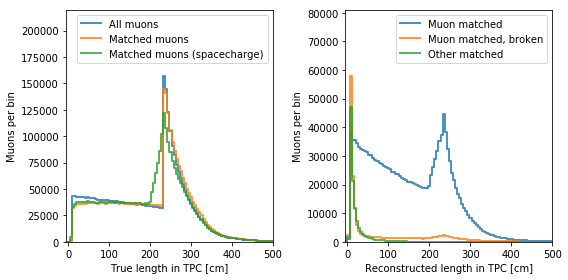

In [37]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))

N=100
x_min=-5
x_max=500

data=[df_mc_muon_cross['mc_length_tpc'], 
      df_mc_muon_cross_matched['track_matched_length_tpc'], 
      df_mc_muon_cross_matched['track_matched_length_sce']]
labs=['All muons', 'Matched muons', 'Matched muons (spacecharge)']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
scale = [1, len(df_mc_muon_cross)/len(df_mc_muon_cross_matched),len(df_mc_muon_cross)/len(df_mc_muon_cross_matched)]

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend()
ax[0].set_xlabel(r'True length in TPC [cm]')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0, max_y*1.4)


data = [df['track_length'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'Reconstructed length in TPC [cm]')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_ylim(0, max_y*1.4)

fig.tight_layout()
plt.savefig(outdir+"tracklength.pdf", bbox_inches="tight")

[  9.05201278  11.65964439  14.4031662   21.76765012  29.32331402
  40.60618494  51.75989737  61.47249358  72.17954929  74.87013061
  96.13839645 118.36783941 134.6744571  143.88344599 151.33780502
 158.52528205 169.36495407 185.14679329 190.97790204 202.75778603]
[ 9.20090714 11.91996079 10.81510861 12.46271351 13.76594625 14.9105696
 16.48157978 17.6147274  23.33268508 19.69907889 21.36428929 25.35355129
 24.50360574 23.60886989 25.72359157 26.9384081  29.67427271 38.39201257
 35.17548066 32.17524948]


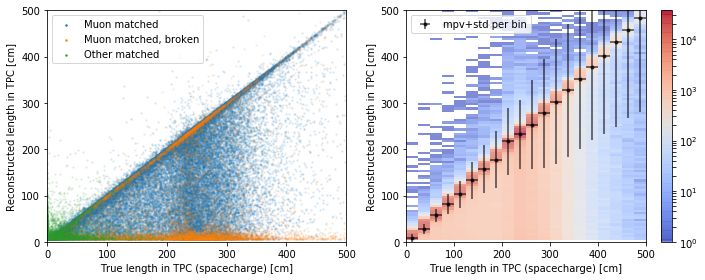

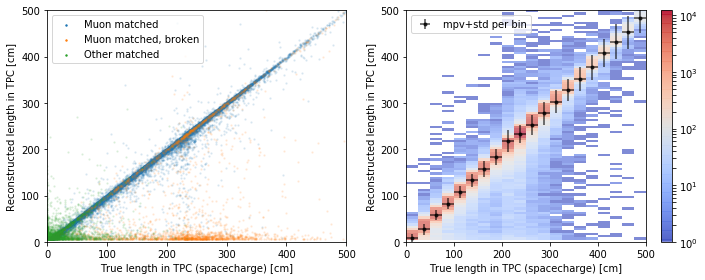

In [38]:
y_max = 500
for q_on, name in zip([-1,0], ['all', 'good']):
    fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=False, figsize=(10,4))
    fld_mc, fld_reco = 'track_matched_length_sce', 'track_length'

    for df,lab in zip(df_arr,label_arr):
        temp = df.query('time_drift_ok>@q_on').sample(frac=scatter_fraq)
        ax[0].scatter(temp[fld_mc],
                      temp[fld_reco],s=2,alpha=0.1,label=lab)
        leg = ax[0].legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0].query('time_drift_ok>@q_on')[fld_mc],df_arr[0].query('time_drift_ok>@q_on')[fld_reco], label = label_arr[0], 
                                        cmap='coolwarm', bins=(20,100), alpha= 0.65, norm=colors.LogNorm(), range=((0,y_max),(0,y_max)))
    #,norm=colors.LogNorm())
    clb = fig.colorbar(im, ax=ax[1])

    mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
    x_width = x_edges[1] - x_edges[0]
    y_mean = []
    y_err = []
    for n in h:
        mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
        mean = np.average(mids_y, weights=n)
        mean = mids_y[np.argmax(n)]
        var = np.average((mids_y - mean)**2, weights=n)
        y_err.append(np.sqrt(var))
        y_mean.append(mean)
    print(np.array(y_err))
    ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mpv+std per bin', alpha=0.7)
    ax[1].legend(loc='upper left')

    ax[0].set_xlabel('True length in TPC (spacecharge) [cm]')
    ax[0].set_ylabel('Reconstructed length in TPC [cm]')
    ax[1].set_xlabel('True length in TPC (spacecharge) [cm]')
    ax[1].set_ylabel('Reconstructed length in TPC [cm]')
    ax[0].set_ylim(0,y_max)
    
    fig.tight_layout()
    plt.savefig(outdir+"tracklength_2d_"+name+"timing.png", bbox_inches="tight", dpi=300)

In [ ]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=False, figsize=(10,4))
fld_mc, fld_reco = 'track_matched_length_sce', 'track_length'

q_on=0
for df,lab in zip(df_arr,label_arr):
    temp = df.query('time_drift_ok>@q_on').query(clean_query).sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],
                  temp[fld_reco],s=2,alpha=0.1,label=lab)
    leg = ax[0].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_mc],
                                    df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_reco], 
                                    label = label_arr[0], cmap='coolwarm', bins=(20,100), alpha= 0.65, 
                                    norm=colors.LogNorm(), range=((0,y_max),(0,y_max)))
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n in h:
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    mean = np.average(mids_y, weights=n)
    mean = mids_y[np.argmax(n)]
    var = np.average((mids_y - mean)**2, weights=n)
    y_err.append(np.sqrt(var))
    y_mean.append(mean)
print(np.array(y_err))
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mpv+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')

ax[0].set_xlabel('True length in TPC (spacecharge) [cm]')
ax[0].set_ylabel('Reconstructed length in TPC [cm]')
ax[1].set_xlabel('True length in TPC (spacecharge) [cm]')
ax[1].set_ylabel('Reconstructed length in TPC [cm]')
ax[0].set_ylim(0,y_max)
    
fig.tight_layout()
#plt.savefig(outdir+"tracklength_2d_25_goodtime.png", bbox_inches="tight", dpi=300)

## Data MC Plots

In [43]:
track_zenith = {
    "name": 'pfp_zenith_traj',
    "bins": 100,
    "x_min": 0,
    "x_max": np.pi/2,
    "x_label": r"Zenith angle of reconstructed track [rad]",
    "x_ticks": [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2],
    "x_labels": [r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2']
}

track_azimuth = {
    "name": 'pfp_azimuth_traj',
    "bins": 100,
    "x_min": -np.pi,
    "x_max": np.pi,
    "x_label": r"Azimuthal angle of reconstructed track [rad]",
    "x_ticks": [-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
    "x_labels": [r"$-\pi$", r"$-3\pi/4$", r"$-\pi/2$", r"$-\pi/4$", "0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]
}

track_length = {
    "name": 'track_length',
    "bins": 100,
    "x_min": 0,
    "x_max": 350,
    "x_label": r"Track length [cm]",
}

list_plot = [track_zenith, track_azimuth, track_length]

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


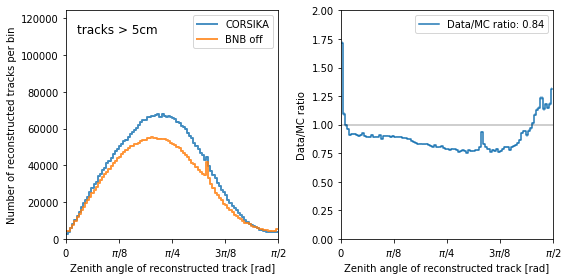

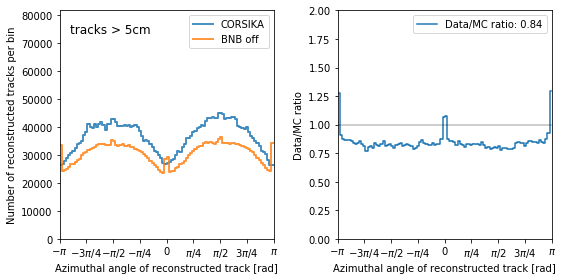

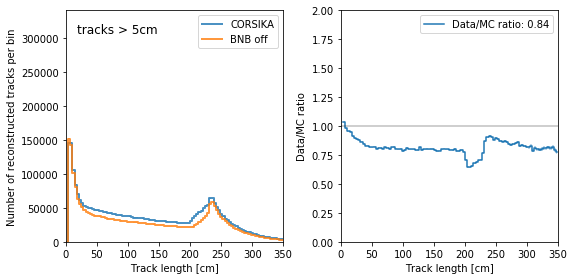

In [45]:
clean = False

scale = [mc_scale, 1]

for s in list_plot:
    fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))
    if clean:
        data = [df_pfp_mc.query(clean_query)[s["name"]], df_pfp_data.query(clean_query)[s["name"]]]
    else:
        data = [df_pfp_mc[s["name"]], df_pfp_data[s["name"]]]
    edges, edges_mid, bins, err, max_y = histHelper(s["bins"], s["x_min"], s["x_max"], data)
    labs=['CORSIKA', 'BNB off']
    for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
        ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
        ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
        
    ax[0].set_ylim(0,max_y*1.1*mc_scale)
    ax[0].set_xlabel(s["x_label"])
    ax[0].set_ylabel("Number of reconstructed tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend()
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[1]/(bins[0]*scale[0])
    ratio_err = 1/np.sqrt(bins[1]) #only do the error on data, mc error is super tiny
    ax[1].step(edges_mid, ratio, where='mid', label = r"Data/MC ratio: {0:.2f}".format(sum(bins[1])/sum(bins[0]*scale[0])))
    ax[1].fill_between(edges_mid, ratio -ratio_err, ratio +ratio_err, alpha=0.3, step='mid')
    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC ratio")
    ax[1].set_ylim(0.0,2.0)
    ax[1].legend()
    plt.tight_layout()
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.05
    if clean:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.9, 'tracks > 25cm', fontsize=12)
        plt.savefig(outdir+s["name"]+"_25cm.pdf")
    else:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.9, 'tracks > 5cm', fontsize=12)
        plt.savefig(outdir+s["name"]+"_5cm.pdf")

## Demonstrate that MCS momentum is not working well

[0.22376368 0.37144259 0.53922634 0.65737467 0.70676271 0.75469576
 0.75979886 0.76062048 0.76219093 0.79331274 0.77246523 0.75915121
 0.79091782 0.79033087 0.76049131 0.7769668  0.75866789 0.76619623
 0.7926331  0.7842844 ]


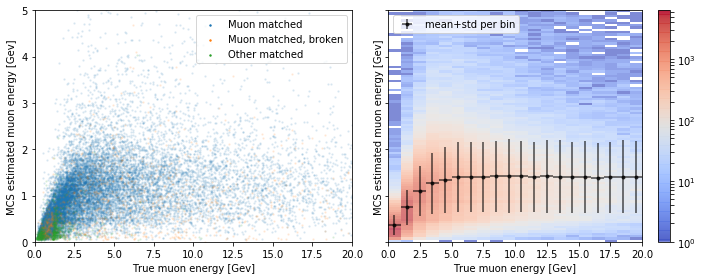

In [39]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=True, figsize=(10,4))
fld_mc, fld_reco = 'track_matched_energy', 'track_mcs_energy'

q_on=0
for df,lab in zip(df_arr,label_arr):
    temp = df.query('time_drift_ok>@q_on').query(clean_query).sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],
                  temp[fld_reco],s=2,alpha=0.1,label=lab)
    leg = ax[0].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_mc],
                                    df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_reco], 
                                    label = label_arr[0], cmap='coolwarm', bins=(20,100), alpha= 0.65, 
                                    norm=colors.LogNorm(), range=((0,20),(0,5)))
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n in h:
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    mean = np.average(mids_y, weights=n)
    var = np.average((mids_y - mean)**2, weights=n)
    y_err.append(np.sqrt(var))
    y_mean.append(mean)
print(np.array(y_err))
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mean+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')

ax[0].set_xlabel('True muon energy [Gev]')
ax[0].set_ylabel('MCS estimated muon energy [Gev]')
ax[1].set_xlabel('True muon energy [Gev]')
ax[1].set_ylabel('MCS estimated muon energy [Gev]')
    
fig.tight_layout()
plt.savefig(outdir+"mcs_2d_25_goodtime.png", bbox_inches="tight", dpi=300)

In [40]:
startx = {
    "field1": 'track_startx',
    "field2": 'track_matched_startx_sce',
    "field3": 'track_matched_startx',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"Start $x$ track: Reco - Truth [cm]"
}

starty = {
    "field1": 'track_starty',
    "field2": 'track_matched_starty_sce',
    "field3": 'track_matched_starty',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"Start $y$ track: Reco - Truth [cm]"
}

startz = {
    "field1": 'track_startz',
    "field2": 'track_matched_startz_sce',
    "field3": 'track_matched_startz',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"Start $z$ track: Reco - Truth [cm]"
}


endx = {
    "field1": 'track_endx',
    "field2": 'track_matched_endx_sce',
    "field3": 'track_matched_endx',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"End $x$ track: Reco - Truth [cm]"
}

endy = {
    "field1": 'track_endy',
    "field2": 'track_matched_endy_sce',
    "field3": 'track_matched_endy',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"End $y$ track: Reco - Truth [cm]"
}

endz = {
    "field1": 'track_endz',
    "field2": 'track_matched_endz_sce',
    "field3": 'track_matched_endz',
    "bins": 50,
    "x_min": -50,
    "x_max": 50,
    "x_label": r"End $z$ track: Reco - Truth [cm]"
}

list_plot = [startx, starty, startz,
             endx, endy, endz]

tolerance = 10

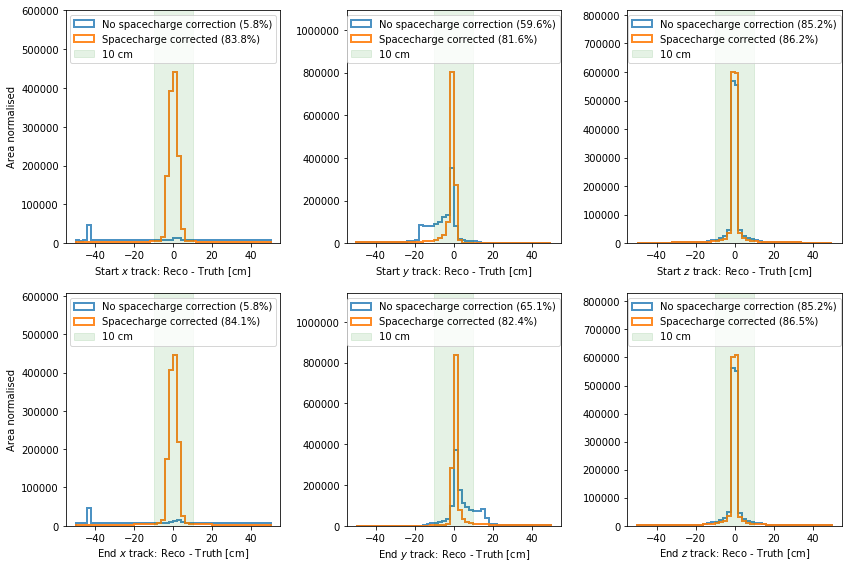

In [42]:
# Make a plot to test the spacecharge for muon matched tracks
fig, ax = plt.subplots(nrows=2, ncols = 3, figsize=(12,8))
ax = ax.flatten()

for i, d in enumerate(list_plot):
    if 'field3' in d:
        data = [df[d['field1']]-df[d['field3']] for df in df_arr]
        
        ratio = sum((data[0]<tolerance)&(data[0]>-1*tolerance))/len(data[0])*100
        ax[i].hist(data[0], histtype='step',density=0, lw=2, alpha=0.8,
                   bins=d['bins'], range=(d['x_min'], d['x_max']), 
                   label= 'No spacecharge correction ({0:.1f}%)'.format(ratio))
        
    data = [df[d['field1']]-df[d['field2']] for df in df_arr]
    ratio = sum((data[0]<tolerance)&(data[0]>-1*tolerance))/len(data[0])*100
    ax[i].hist(data[0], histtype='step',density=0, lw=2, alpha=0.9,
               bins=d['bins'], range=(d['x_min'], d['x_max']),
               label= 'Spacecharge corrected ({0:.1f}%)'.format(ratio))
    ax[i].axvspan(-1*tolerance, tolerance, color="green", label='10 cm', alpha=0.1)
    ax[i].set_xlabel(d['x_label'])
    ax[i].legend(loc= 'upper center')
    ax[i].set_ylim(0,1.3*ax[i].get_ylim()[1])
    
ax[0].set_ylabel("Area normalised")
ax[3].set_ylabel("Area normalised")
fig.tight_layout()
fig.savefig(outdir+"start_end_resolution.pdf", bbox_inches="tight")